In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Get dataset to train

In [3]:
import json
import torch    #if error, restart kernel
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import glob
import pandas as pd

import os

Fs = 100  # Sampling frequency

# Path to the folder containing the CSV files
folder_path = "TFO Data" + os.sep + "PPG" + os.sep + "Clean PPG"

# Get the list of CSV files in the folder
file_list = glob.glob(folder_path + os.sep + "*.csv")
file_path = file_list[0]

# Read the CSV file into a pandas dataframe
df = pd.read_csv(file_path)
#df = df[df.columns[2:-1]]  # Remove the time, index, and temperature columns
    
# Show the head of the dataframe
title = file_path.split(os.sep)[-1]
print(title)
print(df.shape)
df.head()

HR4.csv
(182480, 10)


,Ch1volts_WL1,Ch2volts_WL1,Ch3volts_WL1,Ch4volts_WL1,Ch5volts_WL1,Ch1volts_WL2,Ch2volts_WL2,Ch3volts_WL2,Ch4volts_WL2,Ch5volts_WL2
0,0.000002,8.812440e-09,7.278859e-10,3.547247e-11,1.230252e-12,4.888189e-07,1.014160e-08,5.066293e-11,1.971175e-12,1.683671e-13
1,0.000002,8.866842e-09,7.359912e-10,3.567527e-11,1.232126e-12,4.941796e-07,1.083115e-08,5.613977e-11,2.132041e-12,1.813407e-13
2,0.000002,8.932950e-09,7.450155e-10,3.590589e-11,1.234843e-12,5.001466e-07,1.155518e-08,6.215791e-11,2.304295e-12,1.951288e-13
3,0.000002,9.013877e-09,7.551500e-10,3.617334e-11,1.238755e-12,5.067280e-07,1.231436e-08,6.875983e-11,2.488521e-12,2.097654e-13
4,0.000002,9.112364e-09,7.665012e-10,3.648827e-11,1.244208e-12,5.138828e-07,1.310927e-08,7.598956e-11,2.685308e-12,2.252847e-13


### Normalize data in dataframe

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

columns = df.columns
index = df.index

# Normalize the data
scaler = StandardScaler() # Can't use this with BCELoss
#scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns, index=index)
df.head()

,Ch1volts_WL1,Ch2volts_WL1,Ch3volts_WL1,Ch4volts_WL1,Ch5volts_WL1,Ch1volts_WL2,Ch2volts_WL2,Ch3volts_WL2,Ch4volts_WL2,Ch5volts_WL2
0,-0.538759,-0.664989,-0.499580,-0.343222,-0.312601,-0.609809,-0.277720,-0.730452,-0.644684,-0.463153
1,-0.482541,-0.659695,-0.485675,-0.325992,-0.306380,-0.589670,-0.244317,-0.723975,-0.631475,-0.439833
2,-0.414578,-0.653261,-0.470194,-0.306398,-0.297368,-0.567252,-0.209244,-0.716858,-0.617330,-0.415049
3,-0.335063,-0.645385,-0.452809,-0.283676,-0.284387,-0.542527,-0.172469,-0.709051,-0.602202,-0.388740
4,-0.245473,-0.635800,-0.433336,-0.256919,-0.266294,-0.515648,-0.133962,-0.700501,-0.586042,-0.360844


In [5]:
x = df['Ch1volts_WL1']
y = df['Ch2volts_WL1']
print(x.shape)
print(y.shape)

(182480,)
(182480,)


## Create model and dataloaders

In [6]:
from Utils.models import VAE
from Utils.dataloader import DataLoaderGenerator
from Utils.processing import window_data

# Window the data
# data = window_data(x, 100)
data_x = window_data(x, 100)
data_y = window_data(y, 100)
# print(f"Data shape: {data.shape}")
print(f"Data shape: {data_x.shape}")
print(f"Data shape: {data_y.shape}")

# Create a DataLoader object
#dataloader = DataLoaderGenerator(data, batch_size=32)
dataloader = DataLoaderGenerator([data_x, data_y], batch_size=32)
#train_loader, val_loader = dataloader.generate()
train_loader = dataloader.generate()
print(f"Number of batches: {len(train_loader)}")

# Initialize the model
vae = VAE(input_dims=100, latent_dims=6)#, device='cpu')


Data shape: (182381, 100)
Data shape: (182381, 100)
Number of batches: 11398


In [7]:
from torchsummary import summary
if torch.cuda.is_available():
    vae = vae.to('cuda')
print(vae)
summary(vae, (1, 100))

VAE(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(31,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(21,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(11,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv1d(128, 512, kernel_size=(4,), stride=(2,), padding=(5,))
    (10): LeakyReLU(negative_slope=0.01)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=12288, out_features=24, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=24, bias=True)
    (1): LeakyReLU(negat

## Train Model

In [8]:
train_save = False
if train_save:
    # Train the model
    vae.train_model(train_loader, n_epochs=10)
    # Save the model
    vae.save_model("Weights/vae_ppg.pth")
else:
    # Load the model
    vae.load_model("Weights/vae_ppg.pth")
    vae.eval()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### Loss Analysis

In [ ]:
if train_save:
    vae.plot_loss()

## Create LSTM data and model

In [ ]:
encoded_training_data = vae.encode_data(train_loader)

In [ ]:
print(encoded_training_data.shape)

(201536, 6)


In [ ]:
# Create a DataLoader object
lstm_dataloader = DataLoaderGenerator(encoded_training_data, batch_size=32)
#train_loader_lstm, val_loader_lstm = lstm_dataloader.generate()
train_loader_lstm = lstm_dataloader.generate()

In [ ]:
train_loader_lstm.dataset.tensors[0].shape

torch.Size([201536, 1, 6])

In [ ]:
from Utils.models import LSTM
from torchinfo import summary as summary2

lstm = LSTM()
if torch.cuda.is_available():
    lstm = lstm.to('cuda')
print(lstm)
summary2(lstm, input_size=(1, 6))

LSTM(
  (models): ModuleList(
    (0): LSTM(6, 64, batch_first=True)
    (1): LSTM(64, 64, batch_first=True)
    (2): LSTM(64, 6, batch_first=True)
    (3): Linear(in_features=6, out_features=6, bias=True)
  )
)


Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 6]                    --
├─ModuleList: 1-1                        --                        --
│    └─LSTM: 2-1                         [1, 64]                   18,432
│    └─LSTM: 2-2                         [1, 64]                   33,280
│    └─LSTM: 2-3                         [1, 6]                    1,728
│    └─Linear: 2-4                       [1, 6]                    42
Total params: 53,482
Trainable params: 53,482
Non-trainable params: 0
Total mult-adds (M): 3.32
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.22

## Train LSTM

In [ ]:
train_save = False
if train_save:
    # Train the model
    lstm.train_model(train_loader_lstm, n_epochs=10)
    # Save the model
    lstm.save_model("Weights/lstm_ppg.pth")
else:
    # Load the model
    lstm.load_model("Weights/lstm_ppg.pth")
    lstm.eval()

In [ ]:
if train_save:
    lstm.plot_loss()

## Evaluate VAE-LSTM Model

In [ ]:
from Utils.models import VAE_LSTM

vae_lstm = VAE_LSTM(vae, lstm)

In [16]:
import numpy as np
import glob
import os

basefile = file_path.split(os.sep)[-1].replace('.csv', '')

directory = "TFO Data" + os.sep + "PPG" + os.sep + "Artificial Anomalies" + os.sep + "datafiles"
file_list = glob.glob(directory + os.sep + f"{basefile}*.csv")

random_file = np.random.choice(file_list)
key = random_file.split('_')[-1].split('.')[0]
anomalous_data = pd.read_csv(random_file)

directory = "TFO Data" + os.sep + "PPG" + os.sep + "Artificial Anomalies" + os.sep + "anomaly indices"

file_list = glob.glob(directory + os.sep + f"*_{key}.csv")
file_path_indices = file_list[0] if file_list else None

if file_path_indices:
    anomaly_indices = pd.read_csv(file_path_indices)
else:
    anomaly_indices = None

test_data = anomalous_data['Ch1volts_WL1']
anomalies = anomaly_indices['Ch1volts_WL1']
anomalies = np.array(anomalies)
print(f"Anomalies: {anomalies}")    

Anomalies: [False False False ... False False False]


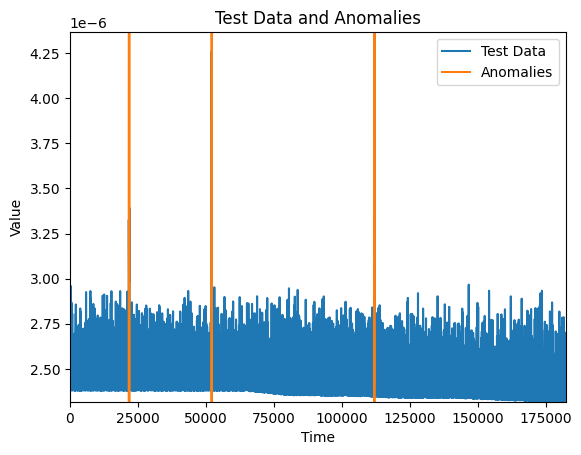

In [20]:
import matplotlib.pyplot as plt

# Scale the anomalies to match the height of the test data
scaled_anomalies = anomalies * test_data.max()

# Plot test_data
plt.plot(test_data, label='Test Data')

# Plot scaled anomalies
plt.plot(scaled_anomalies, label='Anomalies')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Test Data and Anomalies')

# Set x-axis limits
plt.xlim(test_data.index.min(), test_data.index.max())

# Set y-axis limits
plt.ylim(test_data.min(), test_data.max())

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
import numpy as np

if isinstance(anomalies, np.ndarray) and anomalies.dtype == bool:
    print("anomalies is a numpy array of booleans")
else:
    print("anomalies is not a numpy array of booleans")

anomalies is a numpy array of booleans


Threshold: 0.1, Precision: 0.10164908776459698, Recall: 0.4069234519746465, F1 Score: 0.162664691666017
	Augmented Precision: 0.21756656412432376, Augmented Recall: 1.0, Augmented F1 Score: 0.35737933437881164
Threshold: 0.125, Precision: 0.1015185671464315, Recall: 0.39960994636762553, F1 Score: 0.16190589071945005
	Augmented Precision: 0.22042386725131116, Augmented Recall: 1.0, Augmented F1 Score: 0.361225100829532
Threshold: 0.15000000000000002, Precision: 0.10152527417118366, Recall: 0.39268649439297904, F1 Score: 0.161338141025641
	Augmented Precision: 0.22345455733989933, Augmented Recall: 1.0, Augmented F1 Score: 0.3652846049725725
Threshold: 0.17500000000000002, Precision: 0.10162528564459393, Recall: 0.38595806923451975, F1 Score: 0.16088776878988656
	Augmented Precision: 0.2266598886040138, Augmented Recall: 1.0, Augmented F1 Score: 0.3695562082199679
Threshold: 0.2, Precision: 0.10170466429617235, Recall: 0.3793271574841541, F1 Score: 0.16040244933303097
	Augmented Precisio

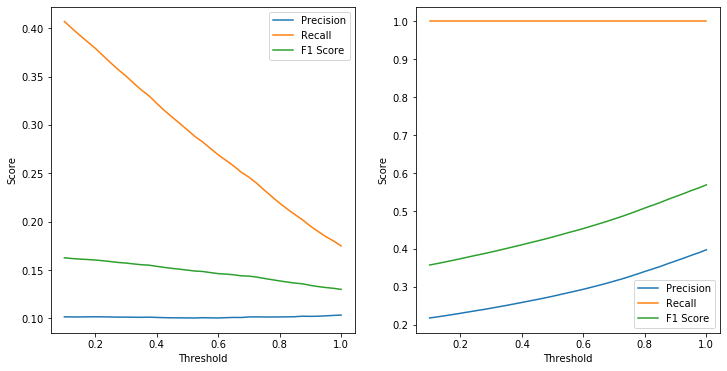

Best threshold: 0.1
Best precision: 0.10164908776459698
Best recall: 0.4069234519746465
Best F1: 0.162664691666017
Best threshold (augmented): 1.0
Best precision (augmented): 0.39746521452656874
Best recall (augmented): 1.0
Best F1 (augmented): 0.5688373641002885


In [ ]:
best_threshold, best_precision, best_recall, best_f1, best_threshold_aug, best_precision_aug, best_recall_aug, best_f1_aug = \
    vae_lstm.evaluate(test_data, anomalies, plot=True)

print(f"Best threshold: {best_threshold}")
print(f"Best precision: {best_precision}")
print(f"Best recall: {best_recall}")
print(f"Best F1: {best_f1}")
print(f"Best threshold (augmented): {best_threshold_aug}")
print(f"Best precision (augmented): {best_precision_aug}")
print(f"Best recall (augmented): {best_recall_aug}")
print(f"Best F1 (augmented): {best_f1_aug}")

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


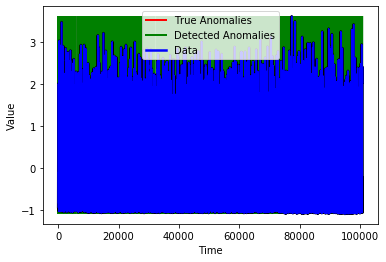

In [ ]:
vae_lstm.plot_anomaly(test_data, best_threshold, None)

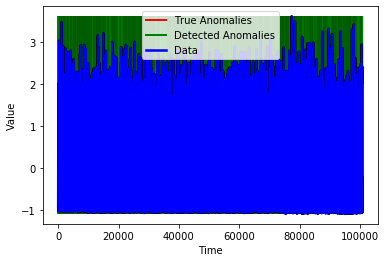

In [ ]:
vae_lstm.plot_anomaly(test_data, best_threshold, anomalies)